In [1]:
from util.gen_utils import *
from util.qc_util import *
from util.qpcr_utils import *

import os

%matplotlib inline

%load_ext autoreload
%autoreload 2

# Load raw data
* Discovery = RNAseq
* Validation = RNAseq

In [2]:
#All data
path_prefix = '../../data/rnaseq_stanford_all/'
all_stnfd_data  = {'rnaseq' : rnaseq_data(counts_df_path = path_prefix + 'htseq_merged.csv'),
             'sample_meta' : read_sample_meta_table(path_prefix + 'init_sample_data.csv'),
             'subj_meta' : read_sample_meta_table(path_prefix + 'init_subj_data.csv'),
             'qc' : read_qc_data(path_prefix + 'outlier_data.txt'), 
             'pe_addntl_subj_meta' : read_sample_meta_table(path_prefix + 'pe_subj_metadata.csv')
             }

all_stnfd_data['sample_meta'] = all_stnfd_data['sample_meta'].reindex(all_stnfd_data['rnaseq'].counts.columns).dropna() #Not all sequenced

gapps_path_prefix = '../../data/gapps/'
gapps_data = {'rnaseq' : rnaseq_data(counts_df_path = gapps_path_prefix + 'htseq_merged.csv'),
              'sample_meta' : read_sample_meta_table(gapps_path_prefix + 'init_sample_data.csv'),
              'subj_meta' : read_sample_meta_table(gapps_path_prefix + 'init_subj_data.csv'),
              'qc' : read_qc_data(gapps_path_prefix + 'outlier_data.txt'), 
             }

In [3]:
batch_masks = {batch_id : all_stnfd_data['sample_meta'].batch == batch_id for batch_id in sorted(all_stnfd_data['sample_meta'].batch.unique())}
s2_split_mask_by_subj = all_stnfd_data['sample_meta'].loc[batch_masks['s2']].drop_duplicates(subset = 'subject').sample(frac = 0.6, random_state = 37).subject
s2_split_mask = all_stnfd_data['sample_meta'].loc[all_stnfd_data['sample_meta'].subject.isin(s2_split_mask_by_subj.to_list())].index

discovery_idx = all_stnfd_data['sample_meta'].loc[batch_masks['s1']].index.union(s2_split_mask)
validation_idx = all_stnfd_data['sample_meta'].index.difference(discovery_idx)

discovery_data = split_stnfd_rnaseq_meta_dict(all_stnfd_data, discovery_idx)
validation_data = split_stnfd_rnaseq_meta_dict(all_stnfd_data, validation_idx)

discovery_path_prefix = path_prefix + 'discovery/' 
val_path_prefix = path_prefix + 'val/'

# ID outlier samples
* For RNAseq - Based on QC metrics
    * QC measures:
        1. Sample degradation
        2. N reads that map to genes
        3. Possible DNA contamination (DNAse used but regardless)

In [4]:
print('N samples failed QC = %d' % (all_stnfd_data['qc'].Outlier.sum() - 16)) #16 H2O samples

N samples failed QC = 107


# Visualize QC data 
For RNAseq
* Use heatmap to visualize whether outlier samples cluster separately
* Use PCA to visualize logCPM values pre and post outlier sample filtering

Discovery
7160 genes (Fraction = 0.117928) passed cutoff
209 samples (0.73) passed QC
Validation
106 samples (0.79) passed QC
GAPPs
89 samples (0.99) passed QC


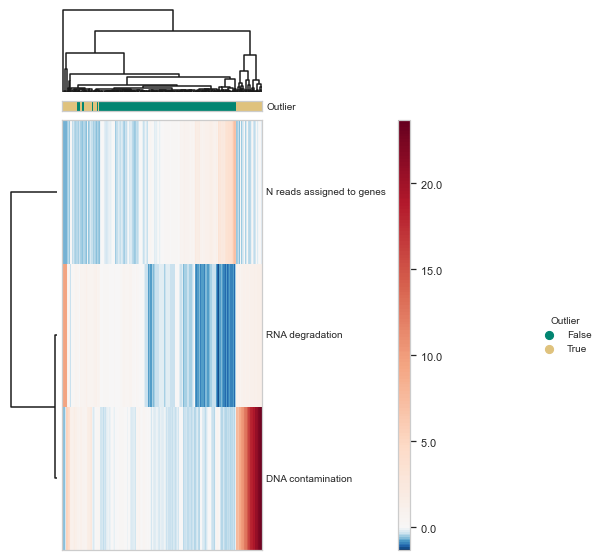

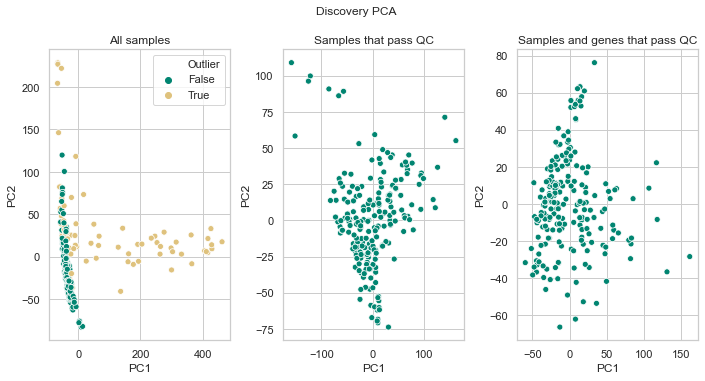

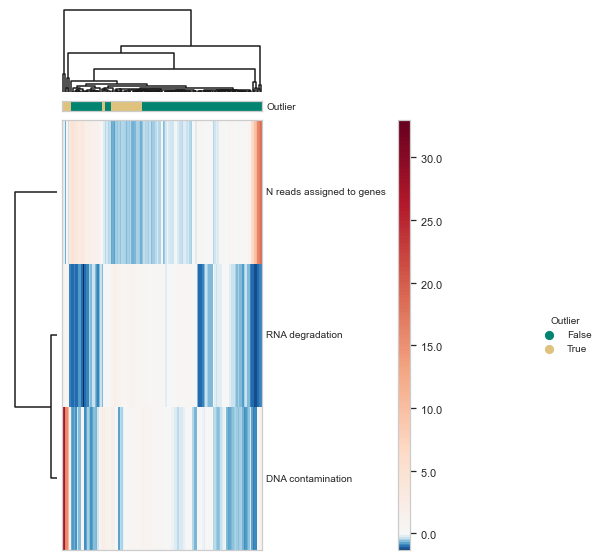

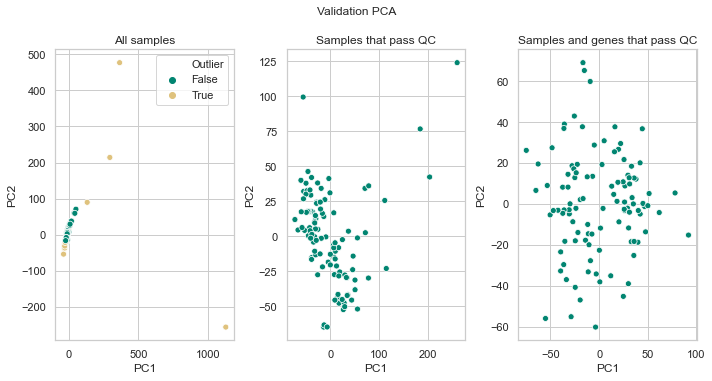

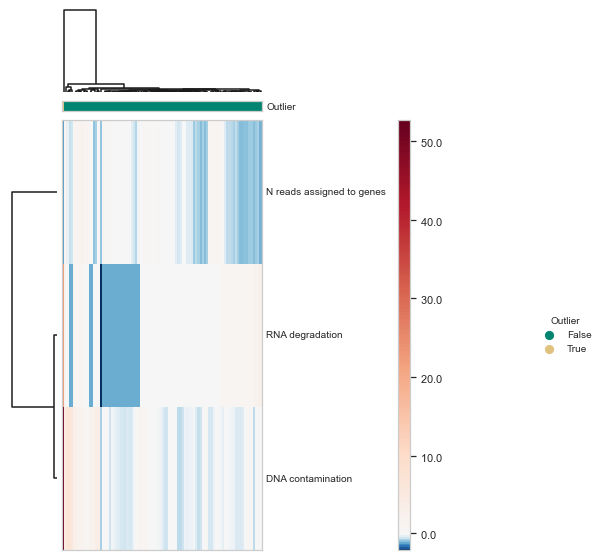

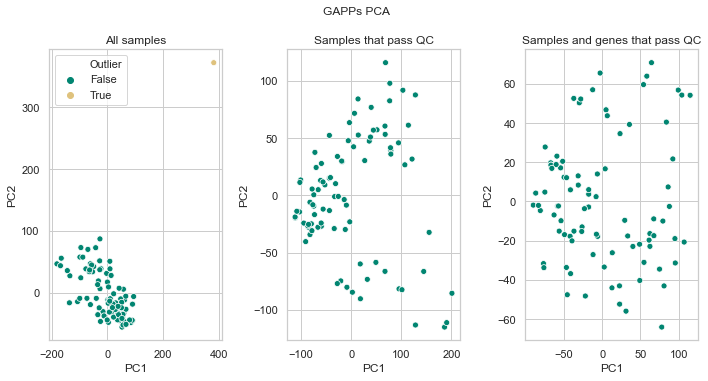

In [5]:
qc_out = {}
cohort_stats = {}
for dataset, data_tuple in {'Discovery' : ('RNAseq', discovery_data, "out/qc/discovery/"),
                           'Validation' : ('RNAseq', validation_data, "out/qc/validation/"),
                           'GAPPs' : ('RNAseq', gapps_data, "out/qc/gapps/")}.items():
    
    data_type, data, plot_save_path = data_tuple
    frac_samples_exp_cutoff = 0.75 
    qc_out[dataset] = {}
    
    qc_out[dataset]['samples_passed_qc'] = data['qc'].loc[~(data['qc'].Outlier)].index
    #Cohort stats, Tuple (Pre, Post)
    cohort_stats[dataset] = (data['subj_meta'].reset_index().groupby('case').count().iloc[:, 0].to_numpy(), #NP array 0 = NT, 1 = PE
                             data['sample_meta'].loc[qc_out[dataset]['samples_passed_qc']].join(data['subj_meta'], on = 'subject').drop_duplicates('subject').groupby('case').count().iloc[:, 0].to_numpy())
    
    #After this point, RNAseq specific QC
    if data_type != 'RNAseq':
        continue
        
    print(dataset)
    if dataset == 'Discovery':
        qc_out[dataset]['gene_qc_mask'] = filter_genes_CPMcutoff(data['rnaseq'].CPM.loc[:, qc_out[dataset]['samples_passed_qc']], CPM_cutoff = 0.5, frac_samples_exp = frac_samples_exp_cutoff)
    else:
        qc_out[dataset]['gene_qc_mask'] = qc_out['Discovery']['gene_qc_mask'].copy() 
        
    qc_out[dataset]['heatmap'], qc_out[dataset]['pca'] = pca_and_viz_qc(data['qc'], data['rnaseq'].logCPM, qc_out[dataset]['gene_qc_mask'], dataset + " PCA")
    
    check_make_folder(plot_save_path)
    save_figure_pdf(qc_out[dataset]['heatmap'], plot_save_path + "heatmap.pdf")
    save_figure_pdf(qc_out[dataset]['pca'], plot_save_path + "pca.pdf")

# Get cohort stats pre and post QC
* How many people were recruited to participate [Both discovery and validation]?
* Of those, how many were included in the study post QC [Both discovery and validation]?

In [6]:
total_recruited = None
total_included = None

for dataset, cohort_stats_tuple in cohort_stats.items():
    if dataset != 'GAPPs':
        total_recruited = total_recruited + cohort_stats_tuple[0] if total_recruited is not None else cohort_stats_tuple[0]
        total_included = total_included + cohort_stats_tuple[1] if total_included is not None else cohort_stats_tuple[1]
    
    print(dataset)
    print('%d (%d Normotensive, %d PE) people recruited (Pre QC)' % (cohort_stats_tuple[0].sum(), cohort_stats_tuple[0][0], cohort_stats_tuple[0][1]))
    print('%d (%d Normotensive, %d PE) people included (Post QC)' % (cohort_stats_tuple[1].sum(), cohort_stats_tuple[1][0], cohort_stats_tuple[1][1]))
    print()

print('Total = Discovery + Validation')
print('%d (%d Normotensive, %d PE) people recruited (Pre QC)' % (total_recruited.sum(), total_recruited[0], total_recruited[1]))
print('%d (%d Normotensive, %d PE) people included (Post QC)' % (total_included.sum(), total_included[0], total_included[1]))

Discovery
88 (60 Normotensive, 28 PE) people recruited (Pre QC)
73 (49 Normotensive, 24 PE) people included (Post QC)

Validation
43 (34 Normotensive, 9 PE) people recruited (Pre QC)
39 (32 Normotensive, 7 PE) people included (Post QC)

GAPPs
87 (61 Normotensive, 26 PE) people recruited (Pre QC)
87 (61 Normotensive, 26 PE) people included (Post QC)

Total = Discovery + Validation
131 (94 Normotensive, 37 PE) people recruited (Pre QC)
112 (81 Normotensive, 31 PE) people included (Post QC)


#### Filter data based on QC and save clean data
* Add term column: Split into time groups based on gestational age sampling scheme 
    * Groups are approx based on trimesters; however, scheduling can sometimes result in 2 samples in the same term but weeks apart.
    * Split below tries to keep samples within same 1-2 month period 
* Add PE type: Early vs late as defined by 34 week cutoff
* Adjust PP time definition
    * Post-partum samples should not be defined on GA time. Since they are collected following delivery, should be defined as weeks post delivery
* Remove samples and genes that failed QC from counts tables and save clean table
    * Will use these to estimate TMM normalization and for analysis here on out
* Remove samples that failed QC from metadata tables, combine tables, and save
    * Will use these for analysis here on out

In [7]:
for dataset, data_tuple in {'Discovery' : ('RNAseq', discovery_data, discovery_path_prefix),
                            'Validation' : ('RNAseq', validation_data, val_path_prefix),
                            'GAPPs' : ('RNAseq', gapps_data, gapps_path_prefix)}.items():
    
    data_type, data, save_path = data_tuple
    
    print(dataset)
    #Get term data, get early v late onset
    has_pp = True if dataset != 'GAPPs' else False
    data['sample_meta'].insert(0, 'term', get_term_labels(data['sample_meta'], 'ga_at_collection', has_pp = has_pp))
    
    #Join sample + subj meta, add PE type
    data['sample_meta_full'] = data['sample_meta'].join(data['subj_meta'], on = 'subject', how = 'inner')
    data['sample_meta_full'].insert(data['sample_meta_full'].shape[1], 'pe_type', get_pe_type(data['sample_meta_full']))
    
    
    if dataset != 'GAPPs': #No BMI data available for GAPPs
        #Define BMI groups
        bmi = get_bmi_groups(data['sample_meta_full'])
        is_obese = get_bmi_groups(data['sample_meta_full'], new_col = 'is_obese', cutoffs = np.array([30]), labels = ['Obese', 'Not obese'])
        data['sample_meta_full'].insert(data['sample_meta_full'].shape[1], bmi.name, bmi)
        data['sample_meta_full'].insert(data['sample_meta_full'].shape[1], is_obese.name, is_obese)

    #Adjust PP sample collction [should not be on GA time]
    pp_mask = (data['sample_meta_full'].is_pp == 1)
    data['sample_meta_full'].insert(data['sample_meta_full'].shape[1], 'weeks_post_del', np.nan)
    data['sample_meta_full'].loc[pp_mask, 'weeks_post_del'] = data['sample_meta_full'].loc[pp_mask, 'ga_at_collection'] -  data['sample_meta_full'].loc[pp_mask, 'ga_wk_del']
        
    #Add time to pe onset and time to delivery
    data['sample_meta_full']['time_to_pe_onset'] = data['sample_meta_full'].pe_onset_ga_wk - data['sample_meta_full'].ga_at_collection
    data['sample_meta_full']['time_to_delivery'] = data['sample_meta_full'].ga_wk_del - data['sample_meta_full'].ga_at_collection

    #dummy value for when no PE
    data['sample_meta_full'].loc[data['sample_meta_full'].case == 0, 'time_to_pe_onset'] = data['sample_meta_full'].loc[data['sample_meta_full'].case == 0, 'time_to_delivery']
    
    #Save pre QC
    data['sample_meta_full'].to_csv(save_path + 'sample_meta_all_merged.csv')
    
    #Remove samples failed QC, 
    data['sample_meta_full'] = data['sample_meta_full'].loc[qc_out[dataset]['samples_passed_qc']]
    
    data['sample_meta_full'].index.rename('sample', inplace = True)

    #Save post QC
    data['sample_meta_full'].to_csv(save_path + 'sample_meta_postQC.csv')
    
    #Print quick stats about data
    print(data['sample_meta_full'].groupby(['group', 'term']).count().iloc[:, 0])
    print('Total sample n = %d' % data['sample_meta_full'].shape[0])
    
    if data_type == 'RNAseq':
        #Clean up counts table
        counts_samples_clean = data['rnaseq'].counts.loc[:, qc_out[dataset]['samples_passed_qc']]
        counts_clean = data['rnaseq'].counts.loc[qc_out[dataset]['gene_qc_mask'], qc_out[dataset]['samples_passed_qc']]
        print('Counts table now has %d genes and %d samples' % counts_clean.shape)
        counts_samples_clean.to_csv(save_path + 'htseq_postSampleQC_noGeneQC.csv')
        counts_clean.to_csv(save_path + 'htseq_postQC.csv')

Discovery
group    term
Control  1       37
         2       36
         3       39
         4       30
PE       1       13
         2       17
         3       20
         4       17
Name: subject, dtype: int64
Total sample n = 209
Counts table now has 7160 genes and 209 samples
Validation
group    term
Control  1       19
         2       27
         3       19
         4       19
PE       1        3
         2        8
         3        6
         4        5
Name: subject, dtype: int64
Total sample n = 106
Counts table now has 7160 genes and 106 samples
GAPPs
group    term
Control  1       40
         2       21
PE       1       16
         2       12
Name: ga_at_collection, dtype: int64
Total sample n = 89
Counts table now has 7160 genes and 89 samples


# Preprocess independent datasets
* Pull out counts and metadata in form that is compatible with fxns used to load RNAseq data and metadata
* Del Vecchio et al 2020 - SRA Accession No SRP271730
* Munchel et al 2020 - See supp files associated with manuscript (DOI: 10.1126/scitranslmed.aaz0131)

In [8]:
#Delvecchio et al 2020
delvecchio_sample_meta = read_save_delvecchio_meta(biosample_results_path = '../../data/delvecchio_data/biosample_result.txt', 
                                                   sra_results_path = '../../data/delvecchio_data/SraRunTable.txt',
                                                  out_path = "../../data/delvecchio_data/sample_meta.csv")
delvecchio_sample_meta.head()

,subj_id,sample_type,geo_id,BioSample,complication_during_pregnancy,term,case
sample,,,,,,,
SRR12214516,Normal_Pregnancy_Patient_2,delivery,GSM4669902,SAMN15523937,No Complications,NaN,0
SRR12214515,Normal_Pregnancy_Patient_2,3rd_Trimester,GSM4669901,SAMN15523938,No Complications,3.0,0
SRR12214514,Normal_Pregnancy_Patient_2,2nd_Trimester,GSM4669900,SAMN15523939,No Complications,2.0,0
SRR12214513,Normal_Pregnancy_Patient_2,1st_Trimester,GSM4669899,SAMN15523940,No Complications,1.0,0
SRR12214512,Normal_Pregnancy_Patient_1,cord_blood,GSM4669898,SAMN15523941,No Complications,NaN,0


In [9]:
#Munchel et al 2020, S1 - PEARL healthy pregnancy data 
munchel_s1_meta = read_save_munchel_data(filepath = '../../data/munchel_data/aaz0131_Data_file_S1.xlsx', 
                                         cnts_out_path = '../../data/munchel_data/S1_counts_only.csv', 
                                         meta_out_path = '../../data/munchel_data/S1_meta.csv', 
                                         mult_samples_per_person = True, is_all_nt = True)
munchel_s1_meta.head()

,ga_at_collection,term,subject,pe_type,case
AA,11.9,1,AA,CTRL,0
D,11.9,1,D,CTRL,0
Q,11.9,1,Q,CTRL,0
H,12.0,1,H,CTRL,0
X,12.1,1,X,CTRL,0


In [10]:
#Munchel et al 2020, S2 - iPEC - early onset PE dataset at diagnosis 
munchel_s2_meta = read_save_munchel_data(filepath = '../../data/munchel_data/aaz0131_Data_file_S2.xlsx', 
                                         cnts_out_path = '../../data/munchel_data/S2_counts_only.csv', 
                                         meta_out_path = '../../data/munchel_data/S2_meta.csv', 
                                         mult_samples_per_person = False, is_all_nt = False)
munchel_s2_meta.head()

,ga_at_collection,term,subject,pe_type,case
PE,30.7,3,PE,PE,1
PE.1,31.7,3,PE.1,PE,1
PE.2,32.0,3,PE.2,PE,1
CTRL,33.3,3,CTRL,CTRL,0
PE.3,33.1,3,PE.3,PE,1


In [11]:
#Munchel et al 2020, S3 - PEARL-PEC - early and late onset PE dataset at diagnosis
munchel_s3_meta = read_save_munchel_data(filepath = '../../data/munchel_data/aaz0131_Data_file_S3.xlsx', 
                                         cnts_out_path = '../../data/munchel_data/S3_counts_only.csv', 
                                         meta_out_path = '../../data/munchel_data/S3_meta.csv', 
                                         mult_samples_per_person = False, is_all_nt = False)
munchel_s3_meta.head()

,ga_at_collection,term,subject,pe_type,case
CTRL-Late,35.3,3,CTRL-Late,CTRL-Late,0
PE-Early,25.9,3,PE-Early,PE-Early,1
PE-Early.1,26.3,3,PE-Early.1,PE-Early,1
PE-Early.2,27.3,3,PE-Early.2,PE-Early,1
PE-Early.3,27.7,3,PE-Early.3,PE-Early,1
